# Import data

In [42]:
import pandas as pd
import re as re
import networkx as nx
import numpy as np

In [52]:
tweets = pd.read_json('conversations_flat.json', lines=True, convert_dates=True, dtype={'id':'str'})
tweets = tweets.drop(['entities', 'reply_settings', 'source', 'possibly_sensitive', 'lang', 'context_annotations', 'attachments', 'geo'], axis=1)

authors = tweets['author'].to_list()
usernames = []
for user in range(len(authors)):
    usernames.append(tweets['author'][user]['username'])
tweets['user'] = usernames

# Sentiment
df_sen = pd.read_csv('tweet_sentiment.csv', dtype={'id':'str'})
df_sen = df_sen.sort_values(by=['id'])
tweets = tweets.sort_values(by=['id'])
sen = df_sen['sentiment'].tolist()
tweets['sentiment'] = sen
tweets['sentiment'] = tweets['sentiment'].str.replace('Positive', '1')
tweets['sentiment'] = tweets['sentiment'].str.replace('Neutral', '0')
tweets['sentiment'] = tweets['sentiment'].str.replace('Negative', '-1')
tweets['sentiment'] = tweets['sentiment'].astype(int)

# Emotion
df_emo = pd.read_csv('tweet_emotion.csv', dtype={'id':'str'})
df_emo = df_emo.sort_values(by=['id'])
tweets = tweets.sort_values(by=['id'])
emo = df_emo['emotion'].tolist()
tweets['emotion'] = emo

tweets['sadness_bin'] = tweets['emotion'].map(lambda x: 1 if x == 'sadness' else 0)
tweets['joy_bin'] = tweets['emotion'].map(lambda x: 1 if x == 'joy' else 0)
tweets['anger_bin'] = tweets['emotion'].map(lambda x: 1 if x == 'anger' else 0)
tweets['optimism_bin'] = tweets['emotion'].map(lambda x: 1 if x == 'optimism' else 0)

# Hate/offensive
df_hate = pd.read_csv('tweet_hate_offensive.csv', dtype={'id':'str'})
df_hate = df_hate.sort_values(by=['id'])
tweets = tweets.sort_values(by=['id'])
hate = df_hate['hate'].tolist()
off = df_hate['offensive'].tolist()
tweets['hate'] = hate
tweets['offensive'] = off

tweets.head()

,text,public_metrics,in_reply_to_user_id,created_at,id,referenced_tweets,author_id,conversation_id,author,in_reply_to_user,...,withheld,user,sentiment,emotion,sadness_bin,joy_bin,anger_bin,optimism_bin,hate,offensive
7362,@cj_dinenage @ChildrensComm @NHSEngland And au...,"{'retweet_count': 6, 'reply_count': 3, 'like_c...",383238347,2019-10-10 13:20:38+00:00,1182284806446551041,"[{'type': 'replied_to', 'id': '118228149622641...",269965177,1182281496226418688,{'profile_image_url': 'https://pbs.twimg.com/p...,{'profile_image_url': 'https://pbs.twimg.com/p...,...,NaN,TwittleyJules,-1,sadness,1,0,0,0,0.008285,0.113663
7005,@cj_dinenage @ChildrensComm @NHSEngland And au...,"{'retweet_count': 6, 'reply_count': 3, 'like_c...",383238347,2019-10-10 13:20:38+00:00,1182284806446551041,"[{'type': 'replied_to', 'id': '118228149622641...",269965177,1182281496226418688,"{'description': 'Mother of sons, writer of stu...","{'description': 'Gosport MP, mum, wife. RT ≠ e...",...,NaN,TwittleyJules,-1,sadness,1,0,0,0,0.008285,0.113663
7361,@TwittleyJules @cj_dinenage @ChildrensComm @NH...,"{'retweet_count': 8, 'reply_count': 3, 'like_c...",269965177,2019-10-10 13:38:36+00:00,1182289327113621506,"[{'type': 'replied_to', 'id': '118228480644655...",331178901,1182281496226418688,{'profile_image_url': 'https://pbs.twimg.com/p...,{'profile_image_url': 'https://pbs.twimg.com/p...,...,NaN,KeeleyMP,-1,sadness,1,0,0,0,0.008389,0.107454
7004,@TwittleyJules @cj_dinenage @ChildrensComm @NH...,"{'retweet_count': 8, 'reply_count': 3, 'like_c...",269965177,2019-10-10 13:38:36+00:00,1182289327113621506,"[{'type': 'replied_to', 'id': '118228480644655...",331178901,1182281496226418688,{'description': 'Labour MP for Worsley & Eccle...,"{'description': 'Mother of sons, writer of stu...",...,NaN,KeeleyMP,-1,sadness,1,0,0,0,0.008389,0.107454
7360,@TwittleyJules @cj_dinenage @ChildrensComm @NH...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",269965177,2019-10-10 13:41:21+00:00,1182290019698008068,"[{'type': 'replied_to', 'id': '118228480644655...",1095754783191896064,1182281496226418688,{'profile_image_url': 'https://pbs.twimg.com/p...,{'profile_image_url': 'https://pbs.twimg.com/p...,...,NaN,AutismMH,0,optimism,0,0,0,1,0.013243,0.063335


In [53]:
before = tweets[tweets["created_at"] <= "2020-01-01 00:00:00+00:00"]
first_wave = tweets[tweets["created_at"].between("2020-01-21 00:00:00+00:00", "2020-09-01 00:00:00+00:00")]
after_first = tweets[tweets["created_at"] >= "2020-09-01 00:00:00+00:00"]

In [54]:
def find_at_word(text):
    word=re.findall(r'(?<=@)\w+',text)
    return ", ".join(word)

tweets['mention']=tweets['text'].apply(lambda x: find_at_word(x))
tweets.head()

,text,public_metrics,in_reply_to_user_id,created_at,id,referenced_tweets,author_id,conversation_id,author,in_reply_to_user,...,user,sentiment,emotion,sadness_bin,joy_bin,anger_bin,optimism_bin,hate,offensive,mention
7362,@cj_dinenage @ChildrensComm @NHSEngland And au...,"{'retweet_count': 6, 'reply_count': 3, 'like_c...",383238347,2019-10-10 13:20:38+00:00,1182284806446551041,"[{'type': 'replied_to', 'id': '118228149622641...",269965177,1182281496226418688,{'profile_image_url': 'https://pbs.twimg.com/p...,{'profile_image_url': 'https://pbs.twimg.com/p...,...,TwittleyJules,-1,sadness,1,0,0,0,0.008285,0.113663,"cj_dinenage, ChildrensComm, NHSEngland"
7005,@cj_dinenage @ChildrensComm @NHSEngland And au...,"{'retweet_count': 6, 'reply_count': 3, 'like_c...",383238347,2019-10-10 13:20:38+00:00,1182284806446551041,"[{'type': 'replied_to', 'id': '118228149622641...",269965177,1182281496226418688,"{'description': 'Mother of sons, writer of stu...","{'description': 'Gosport MP, mum, wife. RT ≠ e...",...,TwittleyJules,-1,sadness,1,0,0,0,0.008285,0.113663,"cj_dinenage, ChildrensComm, NHSEngland"
7361,@TwittleyJules @cj_dinenage @ChildrensComm @NH...,"{'retweet_count': 8, 'reply_count': 3, 'like_c...",269965177,2019-10-10 13:38:36+00:00,1182289327113621506,"[{'type': 'replied_to', 'id': '118228480644655...",331178901,1182281496226418688,{'profile_image_url': 'https://pbs.twimg.com/p...,{'profile_image_url': 'https://pbs.twimg.com/p...,...,KeeleyMP,-1,sadness,1,0,0,0,0.008389,0.107454,"TwittleyJules, cj_dinenage, ChildrensComm, NHS..."
7004,@TwittleyJules @cj_dinenage @ChildrensComm @NH...,"{'retweet_count': 8, 'reply_count': 3, 'like_c...",269965177,2019-10-10 13:38:36+00:00,1182289327113621506,"[{'type': 'replied_to', 'id': '118228480644655...",331178901,1182281496226418688,{'description': 'Labour MP for Worsley & Eccle...,"{'description': 'Mother of sons, writer of stu...",...,KeeleyMP,-1,sadness,1,0,0,0,0.008389,0.107454,"TwittleyJules, cj_dinenage, ChildrensComm, NHS..."
7360,@TwittleyJules @cj_dinenage @ChildrensComm @NH...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",269965177,2019-10-10 13:41:21+00:00,1182290019698008068,"[{'type': 'replied_to', 'id': '118228480644655...",1095754783191896064,1182281496226418688,{'profile_image_url': 'https://pbs.twimg.com/p...,{'profile_image_url': 'https://pbs.twimg.com/p...,...,AutismMH,0,optimism,0,0,0,1,0.013243,0.063335,"TwittleyJules, cj_dinenage, ChildrensComm, NHS..."


In [55]:
before['mention']=before['text'].apply(lambda x: find_at_word(x))
first_wave['mention']=first_wave['text'].apply(lambda x: find_at_word(x))
after_first['mention']=after_first['text'].apply(lambda x: find_at_word(x))

<ipython-input-55-43faed23c8da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before['mention']=before['text'].apply(lambda x: find_at_word(x))
<ipython-input-55-43faed23c8da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_wave['mention']=first_wave['text'].apply(lambda x: find_at_word(x))
<ipython-input-55-43faed23c8da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Matching usernames to parties

In [56]:
users = pd.read_json('mps_flat.json', lines=True, convert_dates=True)
all_mps = pd.read_excel('mps_uk_2020_.xlsx')
pols = all_mps['uid'].tolist()

In [57]:
all_mps = all_mps.drop_duplicates(subset=['uid'])
df_merge = users.merge(all_mps, right_on='uid', left_on='id', how='inner')
df_merge['party']

0      Conservative
1      Conservative
2      Conservative
3      Conservative
4      Conservative
           ...     
511    Conservative
512    Conservative
513    Conservative
514    Labour Co-op
515    Conservative
Name: party, Length: 516, dtype: object

In [58]:
# Constructing labels for use in Networkx node attributes
labels = zip(df_merge.username, df_merge.party)
labels = dict(labels)

# Sentiment / hate / offensive per user

In [59]:
sen_users_before = before.groupby('user').mean()
sen_users_first = first_wave.groupby('user').mean()
sen_users_after = after_first.groupby('user').mean()

In [60]:
sen_users_before.head()

,in_reply_to_user_id,author_id,conversation_id,sentiment,sadness_bin,joy_bin,anger_bin,optimism_bin,hate,offensive
user,,,,,,,,,,
101_Fritz,137118114.0,2.276355e+08,1.187388e+18,0.0,0.5,0.0,0.5,0.0,0.010138,0.059381
10GrandToes,137118114.0,3.867608e+08,1.187388e+18,1.0,0.0,0.0,0.0,1.0,0.015040,0.031897
1Joshwa,137118114.0,2.187150e+07,1.187388e+18,1.0,0.0,0.0,0.0,1.0,0.012633,0.033017
1PadreWil,137118114.0,9.639001e+17,1.187388e+18,1.0,0.0,0.0,0.0,1.0,0.010447,0.040298
4AdsthePoet,383238347.0,1.750892e+08,1.182281e+18,-1.0,1.0,0.0,0.0,0.0,0.010177,0.093909


In [61]:
# Constructing labels for use in Networkx node attributes
sentiment_dict_before = zip(sen_users_before.index, sen_users_before.sentiment)
sentiment_dict_before = dict(sentiment_dict_before)

sentiment_dict_first = zip(sen_users_first.index, sen_users_first.sentiment)
sentiment_dict_first = dict(sentiment_dict_first)

sentiment_dict_after= zip(sen_users_after.index, sen_users_after.sentiment)
sentiment_dict_after = dict(sentiment_dict_after)

In [62]:
# Constructing labels for use in Networkx node attributes
hate_dict_before = zip(sen_users_before.index, sen_users_before.hate)
hate_dict_before = dict(hate_dict_before)

hate_dict_first = zip(sen_users_first.index, sen_users_first.hate)
hate_dict_first = dict(hate_dict_first)

hate_dict_after= zip(sen_users_after.index, sen_users_after.hate)
hate_dict_after = dict(hate_dict_after)

In [63]:
# Constructing labels for use in Networkx node attributes
off_dict_before = zip(sen_users_before.index, sen_users_before.offensive)
off_dict_before = dict(off_dict_before)

off_dict_first = zip(sen_users_first.index, sen_users_first.offensive)
off_dict_first = dict(off_dict_first)

off_dict_after= zip(sen_users_after.index, sen_users_after.offensive)
off_dict_after = dict(off_dict_after)

In [65]:
# Constructing labels for use in Networkx node attributes
sad_dict_before = zip(sen_users_before.index, sen_users_before.sadness_bin)
sad_dict_before = dict(sad_dict_before)

sad_dict_first = zip(sen_users_first.index, sen_users_first.sadness_bin)
sad_dict_first = dict(sad_dict_first)

sad_dict_after= zip(sen_users_after.index, sen_users_after.sadness_bin)
sad_dict_after = dict(sad_dict_after)

In [66]:
# Constructing labels for use in Networkx node attributes
ang_dict_before = zip(sen_users_before.index, sen_users_before.anger_bin)
ang_dict_before = dict(ang_dict_before)

ang_dict_first = zip(sen_users_first.index, sen_users_first.anger_bin)
ang_dict_first = dict(ang_dict_first)

ang_dict_after= zip(sen_users_after.index, sen_users_after.anger_bin)
ang_dict_after = dict(ang_dict_after)

In [67]:
# Constructing labels for use in Networkx node attributes
joy_dict_before = zip(sen_users_before.index, sen_users_before.joy_bin)
joy_dict_before = dict(joy_dict_before)

joy_dict_first = zip(sen_users_first.index, sen_users_first.joy_bin)
joy_dict_first = dict(joy_dict_first)

joy_dict_after= zip(sen_users_after.index, sen_users_after.joy_bin)
joy_dict_after = dict(joy_dict_after)

In [68]:
# Constructing labels for use in Networkx node attributes
opt_dict_before = zip(sen_users_before.index, sen_users_before.optimism_bin)
opt_dict_before = dict(opt_dict_before)

opt_dict_first = zip(sen_users_first.index, sen_users_first.optimism_bin)
opt_dict_first = dict(opt_dict_first)

opt_dict_after= zip(sen_users_after.index, sen_users_after.optimism_bin)
opt_dict_after = dict(opt_dict_after)

# Generating mention networks

## Before pandemic

In [74]:
users = before['user'].tolist()
mentions = before['mention'].tolist()

In [75]:
# Creating adjadency list for network graph cration
adj_list = [] 

for i in range(len(users)):
    adj_list.append(users[i]+' '+mentions[i].replace(',',' '))

adj_list[53]

'Starchild65 KirstenPeebles  cj_dinenage  ChildrensComm  NHSEngland'

In [76]:
# Writing adjacency list to textfile

textfile = open("before_adjlist.txt", "w")

for element in adj_list:
    textfile.write(element + "\n")
textfile.close()

In [77]:
# Importing adjacency list to directed graph
G_before = nx.Graph()
G_before = nx.read_adjlist('before_adjlist.txt', create_using = nx.DiGraph())
nx.set_node_attributes(G_before, labels, "party")
nx.set_node_attributes(G_before, sentiment_dict_before, "sentiment")
nx.set_node_attributes(G_before, hate_dict_before, "hatespeech")
nx.set_node_attributes(G_before, off_dict_before, "offensivelang")
nx.set_node_attributes(G_before, sad_dict_before, "sadness_bin")
nx.set_node_attributes(G_before, ang_dict_before, "anger_bin")
nx.set_node_attributes(G_before, joy_dict_before, "joy_bin")
nx.set_node_attributes(G_before, opt_dict_before, "optimism_bin")

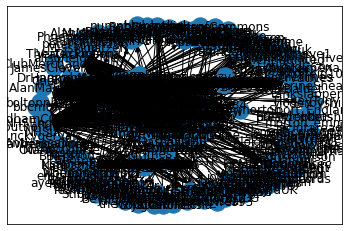

In [78]:
nx.draw_networkx(G_before)

In [79]:
nx.write_gexf(G_before, 'mention_before_network.gexf')

In [95]:
print(nx.average_clustering(G_before))

0.3718172050280574


## First wave

In [80]:
users = first_wave['user'].tolist()
mentions = first_wave['mention'].tolist()

In [81]:
# Creating adjadency list for network graph cration
adj_list = [] 

for i in range(len(users)):
    adj_list.append(users[i]+' '+mentions[i].replace(',',' '))

adj_list[53]

'GarryDoolan2552 justinmadders  NHSEngland'

In [82]:
# Writing adjacency list to textfile
textfile = open("first_wave_adjlist.txt", "w")

for element in adj_list:
    textfile.write(element + "\n")
textfile.close()

In [83]:
# Importing adjacency list to directed graph
G_first = nx.Graph()
G_first = nx.read_adjlist('first_wave_adjlist.txt', create_using = nx.DiGraph())
nx.set_node_attributes(G_first, labels, "party")
nx.set_node_attributes(G_first, sentiment_dict_first, "sentiment")
nx.set_node_attributes(G_first, hate_dict_first, "hatespeech")
nx.set_node_attributes(G_first, off_dict_first, "offensivelang")
nx.set_node_attributes(G_first, sad_dict_first, "sadness_bin")
nx.set_node_attributes(G_first, ang_dict_first, "anger_bin")
nx.set_node_attributes(G_first, joy_dict_first, "joy_bin")
nx.set_node_attributes(G_first, opt_dict_first, "optimism_bin")

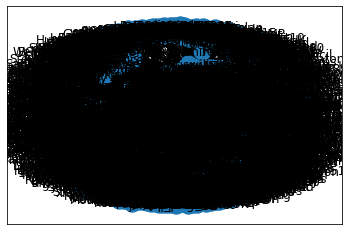

In [84]:
nx.draw_networkx(G_first)

In [85]:
nx.write_gexf(G_first, 'mention_first_wave_network.gexf')

In [94]:
print(nx.average_clustering(G_first))

0.16380538296102667


## After first wave

In [86]:
users = after_first['user'].tolist()
mentions = after_first['mention'].tolist()

In [87]:
# Creating adjadency list for network graph cration
adj_list = [] 
for i in range(len(users)):
    adj_list.append(users[i]+' '+mentions[i].replace(',',' '))
adj_list[53]

'Bec_j87 aliciakearns  NHSEngland  PregnantScrewed  AVMikhailova  BetterBirth1  RWT_NHS'

In [88]:
# Writing adjacency list to textfile

textfile = open("after_first_adjlist.txt", "w")

for element in adj_list:
    textfile.write(element + "\n")
textfile.close()

In [89]:
# Importing adjacency list to directed graph
G_after = nx.Graph()
G_after = nx.read_adjlist('after_first_adjlist.txt', create_using = nx.DiGraph())
nx.set_node_attributes(G_after, labels, "party")
nx.set_node_attributes(G_after, sentiment_dict_after, "sentiment")
nx.set_node_attributes(G_after, hate_dict_after, "hatespeech")
nx.set_node_attributes(G_after, off_dict_after, "offensivelang")
nx.set_node_attributes(G_after, sad_dict_after, "sadness_bin")
nx.set_node_attributes(G_after, ang_dict_after, "anger_bin")
nx.set_node_attributes(G_after, joy_dict_after, "joy_bin")
nx.set_node_attributes(G_after, opt_dict_after, "optimism_bin")

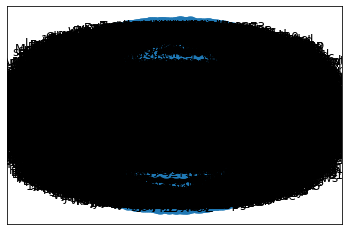

In [90]:
nx.draw_networkx(G_after)

In [92]:
nx.write_gexf(G_after, 'mention_after_first_network.gexf')

In [93]:
print(nx.average_clustering(G_after))

0.2791353698104408


In [96]:
len(tweets)

52302

# Generating reply networks

In [40]:
df_replies = tweets[tweets['in_reply_to_user'].notna()]

In [54]:
df_replies.head()

,text,public_metrics,in_reply_to_user_id,created_at,id,referenced_tweets,author_id,conversation_id,author,in_reply_to_user,__twarc,withheld,user,mention,is_retweet
0,@RobinMillarMP @AlyAShields @BetsiCadwaladr @h...,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",1194759472087998464,2020-10-09 12:17:15+00:00,1314540427874308096,"[{'type': 'replied_to', 'id': '131449302570007...",709375301583835136,1314477726678614016,{'description': 'Raising awareness for PANS Pa...,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,kathryn_gillett,"RobinMillarMP, AlyAShields, BetsiCadwaladr, he...",nan
1,@RobinMillarMP @BetsiCadwaladr @healthdpt @NIC...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1194759472087998464,2020-10-09 11:49:31+00:00,1314533448405614592,"[{'type': 'replied_to', 'id': '131449302570007...",470801601,1314477726678614016,{'entities': {'description': {'urls': [{'start...,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,AlyAShields,"RobinMillarMP, BetsiCadwaladr, healthdpt, NICE...",nan
2,@RobinMillarMP @AlyAShields @BetsiCadwaladr @h...,"{'retweet_count': 4, 'reply_count': 0, 'like_c...",1194759472087998464,2020-10-09 10:12:43+00:00,1314509086596239360,"[{'type': 'replied_to', 'id': '131449302570007...",816444807371517952,1314477726678614016,"{'entities': {'url': {'urls': [{'start': 0, 'e...","{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,soniaserrano0,"RobinMillarMP, AlyAShields, BetsiCadwaladr, he...",nan
3,@AlyAShields @BetsiCadwaladr @healthdpt @NICEC...,"{'retweet_count': 8, 'reply_count': 3, 'like_c...",470801601,2020-10-09 09:08:54+00:00,1314493025700077568,"[{'type': 'replied_to', 'id': '131447772937129...",1194759472087998464,1314477726678614016,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,RobinMillarMP,"AlyAShields, BetsiCadwaladr, healthdpt, NICECo...",nan
4,@BetsiCadwaladr @CALL_247 @MindCymru @Research...,"{'retweet_count': 4, 'reply_count': 1, 'like_c...",470801601,2020-10-09 08:08:07+00:00,1314477729371299840,"[{'type': 'replied_to', 'id': '131447772667861...",470801601,1314477726678614016,{'entities': {'description': {'urls': [{'start...,{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,AlyAShields,"BetsiCadwaladr, CALL_247, MindCymru, ResearchW...",nan


In [62]:
replies = df_replies['in_reply_to_user'].tolist()

tweet_type = []
for user in range(len(replies)):
    try:
        tweet_type.append(replies[user]['username'])
    except:
        tweet_type.append('nan')
df_replies['reply_to_user'] = tweet_type

In [63]:
df_replies.head()

,text,public_metrics,in_reply_to_user_id,created_at,id,referenced_tweets,author_id,conversation_id,author,in_reply_to_user,__twarc,withheld,user,mention,is_retweet,reply_to_user
0,@RobinMillarMP @AlyAShields @BetsiCadwaladr @h...,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",1194759472087998464,2020-10-09 12:17:15+00:00,1314540427874308096,"[{'type': 'replied_to', 'id': '131449302570007...",709375301583835136,1314477726678614016,{'description': 'Raising awareness for PANS Pa...,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,kathryn_gillett,"RobinMillarMP, AlyAShields, BetsiCadwaladr, he...",nan,RobinMillarMP
1,@RobinMillarMP @BetsiCadwaladr @healthdpt @NIC...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1194759472087998464,2020-10-09 11:49:31+00:00,1314533448405614592,"[{'type': 'replied_to', 'id': '131449302570007...",470801601,1314477726678614016,{'entities': {'description': {'urls': [{'start...,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,AlyAShields,"RobinMillarMP, BetsiCadwaladr, healthdpt, NICE...",nan,RobinMillarMP
2,@RobinMillarMP @AlyAShields @BetsiCadwaladr @h...,"{'retweet_count': 4, 'reply_count': 0, 'like_c...",1194759472087998464,2020-10-09 10:12:43+00:00,1314509086596239360,"[{'type': 'replied_to', 'id': '131449302570007...",816444807371517952,1314477726678614016,"{'entities': {'url': {'urls': [{'start': 0, 'e...","{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,soniaserrano0,"RobinMillarMP, AlyAShields, BetsiCadwaladr, he...",nan,RobinMillarMP
3,@AlyAShields @BetsiCadwaladr @healthdpt @NICEC...,"{'retweet_count': 8, 'reply_count': 3, 'like_c...",470801601,2020-10-09 09:08:54+00:00,1314493025700077568,"[{'type': 'replied_to', 'id': '131447772937129...",1194759472087998464,1314477726678614016,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,RobinMillarMP,"AlyAShields, BetsiCadwaladr, healthdpt, NICECo...",nan,AlyAShields
4,@BetsiCadwaladr @CALL_247 @MindCymru @Research...,"{'retweet_count': 4, 'reply_count': 1, 'like_c...",470801601,2020-10-09 08:08:07+00:00,1314477729371299840,"[{'type': 'replied_to', 'id': '131447772667861...",470801601,1314477726678614016,{'entities': {'description': {'urls': [{'start...,{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,AlyAShields,"BetsiCadwaladr, CALL_247, MindCymru, ResearchW...",nan,AlyAShields


In [69]:
before_rp = df_replies[df_replies["created_at"] <= "2020-01-01 00:00:00+00:00"]
first_wave_rp = df_replies[df_replies["created_at"].between("2020-01-21 00:00:00+00:00", "2020-09-01 00:00:00+00:00")]
after_first_rp = df_replies[df_replies["created_at"] >= "2020-09-01 00:00:00+00:00"]

## Before pandemic

In [72]:
users = before_rp['user'].tolist()
replies = before_rp['reply_to_user'].tolist()

In [73]:
# Creating adjadency list for network graph cration
adj_list = [] 

for i in range(len(users)):
    adj_list.append(users[i]+' '+replies[i].replace(',',' '))

adj_list[0]

'LDMSPR CherylJoanDavis'

In [74]:
# Writing adjacency list to textfile

textfile = open("before_adjlist_rp.txt", "w")

for element in adj_list:
    textfile.write(element + "\n")
textfile.close()

In [75]:
# Importing adjacency list to directed graph
G = nx.Graph()
G = nx.read_adjlist('before_adjlist_rp.txt', create_using = nx.DiGraph())
nx.set_node_attributes(G, labels, "party")

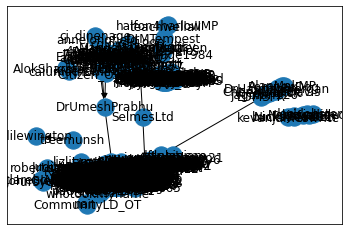

In [76]:
nx.draw_networkx(G)

In [77]:
nx.write_gexf(G, 'rp_before_network.gexf')

## First wave

In [78]:
users = first_wave_rp['user'].tolist()
replies = first_wave_rp['reply_to_user'].tolist()

In [79]:
# Creating adjadency list for network graph cration
adj_list = [] 

for i in range(len(users)):
    adj_list.append(users[i]+' '+replies[i].replace(',',' '))

adj_list[0]

'BrynSeiriol RobinMillarMP'

In [80]:
# Writing adjacency list to textfile

textfile = open("first_wave_rp_adjlist_rp.txt", "w")

for element in adj_list:
    textfile.write(element + "\n")
textfile.close()

In [81]:
# Importing adjacency list to directed graph
G = nx.Graph()
G = nx.read_adjlist('first_wave_rp_adjlist_rp.txt', create_using = nx.DiGraph())
nx.set_node_attributes(G, labels, "party")

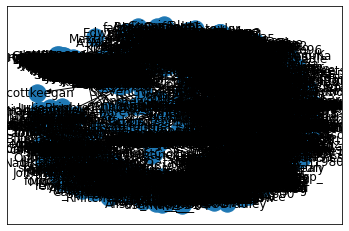

In [82]:
nx.draw_networkx(G)

In [83]:
nx.write_gexf(G, 'rp_first_wave_network.gexf')

## After first wave

In [84]:
users = after_first_rp['user'].tolist()
replies = after_first_rp['reply_to_user'].tolist()

In [85]:
# Creating adjadency list for network graph cration
adj_list = [] 

for i in range(len(users)):
    adj_list.append(users[i]+' '+replies[i].replace(',',' '))

adj_list[0]

'kathryn_gillett RobinMillarMP'

In [86]:
# Writing adjacency list to textfile

textfile = open("after_first_rp_adjlist_rp.txt", "w")

for element in adj_list:
    textfile.write(element + "\n")
textfile.close()

In [87]:
# Importing adjacency list to directed graph
G = nx.Graph()
G = nx.read_adjlist('after_first_rp_adjlist_rp.txt', create_using = nx.DiGraph())
nx.set_node_attributes(G, labels, "party")

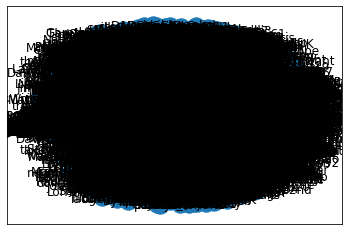

In [88]:
nx.draw_networkx(G)

In [89]:
nx.write_gexf(G, 'rp_after_first_network.gexf')